# Sentiment Analysis vol. 3

Sentiment analysis done on over 2k BBC's unlabeled news articles from 5 categories (business, entertainment, politics, sport and tech). The goal was to predict whether given article makes positive or negative impression about the topic on the reader. 

Method is based on Peak-End rule, where impression is created mostly by peak sentences and end sentences. Thus three vectors are created: <br><br>
&emsp; (1) sentiment vector - each article is split into sentences using spaCy and then each sentence is categorized as negative, neutral or positive (-1, 0, 1)<br>
&emsp; (2) decay vextor - last sentence has weight of 1 and every previous sentence has decreased weight by some small amount (default min: 0.8)<br>
&emsp; (3) peak vector - vector of ones where position of extracted key sentences using BERT is marked by a float higher that 1 (default: 1.3)


Three vectors are multiplied elementwise and then mean is applied. Result is scaled between 0 and 1. 

In [1]:
# read and preprocess articles -- OK

# use spaCy to split articles into sentences -- OK

# use spaCy to classify sentiments of the sentences -- OK

# use BERT to extract peak sentences -- OK

# create 3 vectors for sentences: -- OK
#     neutral [0], positive [1] or negative [-1]
#     reversed weight decay over time
#     apply bigger weights to peak sentences

# combine vectors into final result -- OK

In [36]:
from transformers import pipeline
from summarizer import Summarizer

import glob
import spacy
from spacy.lang.en import English
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [10]:
PATH = 'bbc/**/**'

In [11]:
# read and preprocess the artciles 
def read_articles(path):
    
    articles, topics = [], []
    
    for file in glob.glob(path, recursive=False):
        assert file.endswith('.txt')
        
        topic = file.split('\\')[1]
        topics.append(topic)
        
        with open(file, 'r') as f:
            article = f.read()

            article = article.replace('\n', '')
            article = article.replace("\'", '')                  
            
            articles.append(article)
            
    return tuple(articles), tuple(topics)

In [12]:
articles, topics = read_articles(PATH)

In [13]:
# split every article into list of sentences
def split_articles(articles):
    nlp = English()
    sbd = nlp.add_pipe('sentencizer')
    
    article_sents = []
    
    for article in tqdm(articles):
        doc = nlp(article)
        sents = []
        for sent in doc.sents:
            sents.append(sent.text)
            
        article_sents.append(sents)

    return tuple(article_sents)

In [14]:
article_sents = split_articles(articles)

In [4]:
# class used to categorize senetnces and
# acquire key sentences with extractive summarization using BERT
class ArticleParser:
    
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')
        self.nlp.add_pipe('spacytextblob')
        self.summarizer = Summarizer()
    
    
    # <sentiment analysis>
    def analize_articles(self, articles): # list of articles
        docs = [self.analize_article(article) for article in tqdm(articles)]
        return docs
    
    def analize_article(self, article, return_docs=False):
        if return_docs:
            return [self.nlp(sent) for sent in article]
        return [self.nlp(sent)._.polarity for sent in article]
    # </sentiment analysis>
    
    
    # <summarization>
    def summarize_article(self, article):
        return self.summarizer(article)
    
    def summarize_articles(self, articles): # text articles
        summs = [self.summarize_article(article) for article in tqdm(articles)]
        return summs
    # </summarization>

In [5]:
# function used to merge results into one object
def merge_all(**kwargs):
    renamed = {k: v for k, v in kwargs.items()}
    return renamed

In [6]:
class SentimentAnalyzer:
    
    def __init__(self, data, min_decay=0.8, peak_factor=1.2):
        self.data = data
        for key in ['summaries', 'article_sents', 'sentiments', 'topics']:
            assert key in self.data.keys()
        
        self.min_decay = min_decay
        self.peak_factor = peak_factor
    
    def score(self, index, decay_type='lin'): # exp
        
        # sentiment scores
        sentiments = []
        for value in self.data['sentiments'][index]:
            if value < 0:
                sentiments.append(-1)
            elif value > 0:
                sentiments.append(1)
            else: sentiments.append(0)
        
        # decay factor
        decay = self._decay(len(sentiments), decay_type=decay_type)
        
        # peak sentences
        peaks = self._extract_peaks(self.data['article_sents'][index], self.data['summaries'][index])
        
        # calculate result
        vector = sentiments*decay*peaks
        score = np.sum(vector) / len(vector)
        return score
    
    
    def generate_scores(self):
        scores = [self.score(index) for index in range(len(self.data['topics']))]
        df = pd.DataFrame(zip(scores, self.data['topics']), columns=['Score', 'Topic'])
        return df
            
    
    def _decay(self, length, decay_type):
        # linear decay
        if decay_type == 'lin':
            decay_rate = (1 - self.min_decay) / length
            decays = [1-n*decay_rate for n in range(length)]
            return np.array(decays[::-1])
        
        # exponential decay 
        elif decay_type == 'exp':
            raise NotImplementedError('coming soon-ish ...')

            
    def _extract_peaks(self, article, summary):
        peaks = np.ones((len(article)))
        for idx, art in enumerate(article):
            if art in summary:
                # mark position of every sentence
                peaks[idx] *= self.peak_factor
        return peaks

In [131]:
# useful when rerunning script
try: del parser
except NameError: pass

parser = ArticleParser()

In [15]:
# eta. 5 mins
sentiments = parser.analize_articles(article_sents)

# eta. 110 mins
summaries = parser.summarize_articles(articles)

In [2]:
import pickle

# with open('pickles/sentiments.pkl', 'wb') as fp:
#     pickle.dump(sentiments, fp)
    
# with open('pickles/summaries.pkl', 'wb') as fp:
#     pickle.dump(summaries, fp)

In [3]:
with open('pickles/sentiments.pkl', 'rb') as fp:
    sentiments = pickle.load(fp)
    
with open('pickles/summaries.pkl', 'rb') as fp:
    summaries = pickle.load(fp)

In [15]:
# merging all stuff into one object
data = merge_all(articles=articles, topics=topics, article_sents=article_sents, sentiments=sentiments, summaries=summaries)

In [16]:
analyzer = SentimentAnalyzer(data, min_decay=0.8, peak_factor=1.3)

In [17]:
df = analyzer.generate_scores()

In [21]:
print(df.Score.min())
print(df.Score.max())

-0.6814
1.028


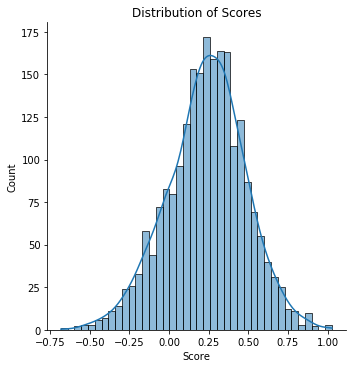

In [68]:
sns.displot(df.Score, bins=40, kde=True).set(title='Distribution of Scores');

In [74]:
# custom scaling to prevent influence from outliers
min_val = np.mean(df.Score.to_numpy()) - 3*np.std(df.Score.to_numpy())
max_val = np.mean(df.Score.to_numpy()) + 3*np.std(df.Score.to_numpy())
print(min_val, '\n' ,max_val)

-0.5046620049460182 
 0.9761288474569081


In [118]:
def custom_scaler(X, min_val, max_val):
    scaled = (X - min_val) / (max_val - min_val)
    
    # clip values between 0 and 1
    for idx in range(len(scaled)):
        if scaled[idx] < 0: 
            scaled[idx] = 0
        elif scaled[idx] > 1: 
            scaled[idx] = 1
    return scaled

In [119]:
scaled = custom_scaler(df.Score.to_numpy(), min_val, max_val)

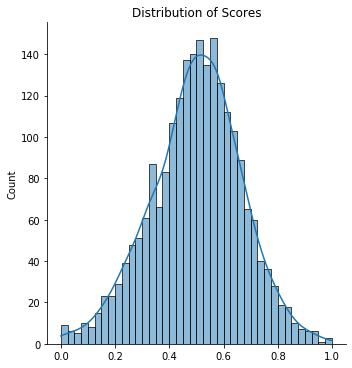

In [120]:
sns.displot(scaled, bins=40, kde=True).set(title='Distribution of Scores');

In [122]:
# assign string label
def calculate_polarity(x, factor=0.5):
    result = ['positive' if value > factor else 'negative' for value in x]
    return result

In [123]:
# scale results between [0, 1], however it is not the greatest solution 
# since articles have various lengths and there is no upper or bottom limit
# of result calculated from 3 vectors
df = df.assign(Scaled=scaled)
pols = calculate_polarity(df['Scaled'])
df = df.assign(Sentiment=pols)

In [124]:
df.sample(10)

,Score,Topic,Scaled,Sentiment
1980,0.209754,tech,0.482456,negative
118,0.246077,business,0.506985,positive
457,0.136267,business,0.432829,negative
811,0.252593,entertainment,0.511385,positive
668,0.502407,entertainment,0.680089,positive
647,0.259306,entertainment,0.515919,positive
1279,0.165355,politics,0.452472,negative
950,0.195296,politics,0.472692,negative
1153,0.247810,politics,0.508155,positive
200,0.380622,business,0.597846,positive


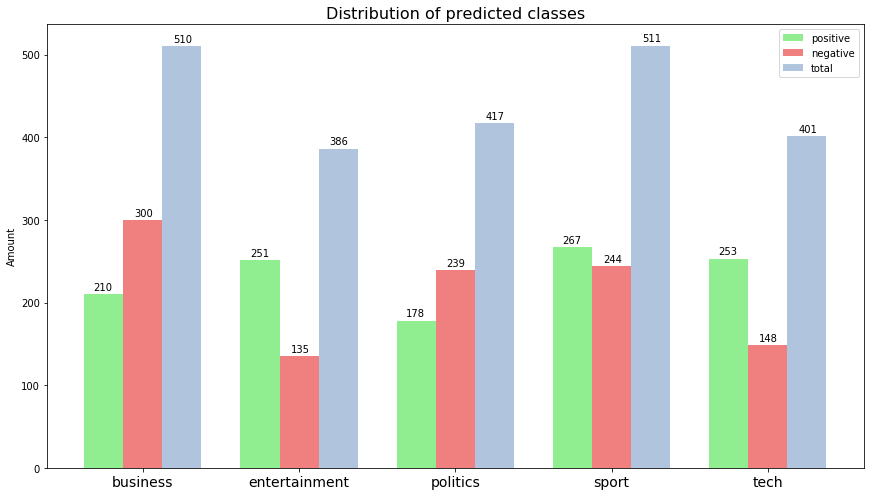

In [125]:
def plot_results(df):
    grps = df.groupby('Topic')
    labels, data = [], []
    for _, grp in grps:
        label = grp['Topic'].iloc[0]
        total = len(grp)
        positive = (grp['Sentiment'].value_counts()['positive'])
        negative = (grp['Sentiment'].value_counts()['negative'])
        data.append([positive, negative, total])
        labels.append(label)
    
    data = np.array(data).T
    fig, ax = plt.subplots(figsize=(12,7))
    X = np.arange(5)
    ax.bar(X + 0.00, data[0], color='lightgreen',     width=0.25, label='positive')
    ax.bar(X + 0.25, data[1], color='lightcoral',     width=0.25, label='negative')
    ax.bar(X + 0.50, data[2], color='lightsteelblue', width=0.25, label='total')
    
    ax.set_title('Distribution of predicted classes', size=16)
    ax.set_xticks(X + 0.25)
    ax.set_xticklabels(labels, size=14)
    
    for i, v in zip(X, data.T):
        ax.text(i - 0.065, v[0] + 5, str(v[0]))
        ax.text(i + 0.195, v[1] + 5, str(v[1]))
        ax.text(i + 0.445, v[2] + 5, str(v[2]))
    
    fig.tight_layout()
    ax.set_ylabel('Amount')
    ax.legend()


plot_results(df)

### Examples

In [132]:
# function used to explore specific parts/results of the model
def show_example(index):    
    summary = parser.summarize_article(articles[index])
    peaks = analyzer._extract_peaks(article_sents[index], summary)
    no_peaks = np.count_nonzero(peaks==1.3)
    
    print('topic:\t\t\t', topics[index])
    print('total sentences:\t', len(article_sents[index]))
    print('extracted sentences:\t', no_peaks)
    v = df['Scaled'].iloc[index]
    print('label:\t\t\t', df['Sentiment'].iloc[index], f'({round(v, 2)})')
    print('index:\t\t\t', index)
    print()
    print()
    print('\t'*6+'**'*5+' SUMMARY '+'**'*5+'\n')
    print(summary)
    print()
    print()
    print('\t'*6+'**'*5+' ORIGINAL '+'**'*5+'\n')
    print(articles[index])
    
    doc = parser.analize_article(article_sents[index], return_docs=True)
    print()
    print()
    print('\t'*6+'**'*5+' POLARITY '+'**'*5)
    print()
    for sent in doc:
        print(sent)
        print('POLARITY:\t', round(sent._.polarity, 2))
        print('\n'+'--'*60+'\n')
    print()
    print()

In [136]:
import random

first  = random.randint(0, len(topics))
second = random.randint(0, len(topics))

In [137]:
show_example(first)

topic:			 entertainment
total sentences:	 11
extracted sentences:	 3
label:			 negative (0.45)
index:			 756


						********** SUMMARY **********

Spears seeks aborted tour paymentSinger Britney Spears is suing eight insurance companies that have refused to reimburse her for cancelling her 2004 world tour. Seven London-based companies and an eighth Paris firm have been given up to 30 days to respond to the complaint. The 22-year-old star initially missed a number of shows on the 82-date tour after injuring her knee during a show in Illinois last March.


						********** ORIGINAL **********

Spears seeks aborted tour paymentSinger Britney Spears is suing eight insurance companies that have refused to reimburse her for cancelling her 2004 world tour.The pop star cancelled her Onyx Hotel tour last June after suffering a knee injury during a video shoot. She is now seeking to be reimbursed for the tours ÂŁ5m ($9.3m) costs in a claim filed at New York State Supreme Court. Seven London-bas

In [138]:
show_example(second)

topic:			 politics
total sentences:	 15
extracted sentences:	 4
label:			 positive (0.56)
index:			 1135


						********** SUMMARY **********

Sport betting rules in spotlightA group of MPs and peers has called for a tightening of regulations controlling betting on sport. The all-party group recommended 15 ways to protect punters and improve the integrity of sports betting. Lord Faulkner of Worcester, who chaired the inquiry, said: "Whilst we accept that the greater part of sports betting is neither corrupt nor unfair to punters, the evidence convinces us that the growth of betting exchanges - because of the facility they provide to bet against a result - has increased the potential for corruption. " This means they can control their odds at winning by placing their money both ways.


						********** ORIGINAL **********

Sport betting rules in spotlightA group of MPs and peers has called for a tightening of regulations controlling betting on sport.The Parliamentary Group on Betting a